In [10]:
import os

import numpy as np
import matplotlib.pyplot as plt

In [58]:
class DTA():
    '''
    The DTA file class.
    The main task is to read and convert binary file with '.dta' extension.
    Both files with the same name and extensions '.dta' and '.dsc' must be in the same directory.
    '.dsc' file consists of list of parameters
    '.dta' file is a binary file with the data, ordered depending on parameters described in '.dsc' file
    filename - name of '.dta' file with extension
    '''
    def __init__(self, filename):
        self.dat_filename = filename
        self.dsc_filename = os.path.splitext(filename)[0] + '.DSC'
        self.dsc_ascii_filename = os.path.splitext(filename)[0] + '_dsc.txt'
        
        self.data = None
        self.x_axis = None
        self.y_axis = None
        self.csv_header = None
        
        self.parameters = self.read_dsc(self.dsc_filename) 
        self.dtype = self.get_dtype()
        
    '''
    Read content of the DSC file 
    Return: dictionary, key - parameter's name (str), value - parameter's value (str)
    '''
    def read_dsc(self, filename):
        parameters = dict()
        with open(filename) as fp:
            lines = fp.readlines()
            for line in lines:
                if line[0] in ['*', '#', '\n', '\t', '.', ' ']:
                    continue
                parameter_lst = line.split()
                parameters[parameter_lst[0]] = ' '.join(parameter_lst[1:])
        return parameters
    
    '''
    Export parameters as an ASCII file. If filename isn't provided, filename with suffix '_dsc' and '.txt' extension will be used.
    Return: None
    '''
    def dsc_export_ASCII(self, filename=None):
        if filename is None:
            filename = os.path.splitext(self.dat_filename)[0] + '_dsc.txt'
        with open(filename, 'w') as fp:
            lines = [(f'{key}\t{val}\n') for key, val in self.parameters.items()]
            fp.writelines(lines)
            
    '''
    Get data type from parameters and load it to dtype variable
    Return: string describing data type in numpy format (e.g. '>f' for float32 big-endian data)
    '''
    def get_dtype(self):
        # if file consists of real numbers
        IRFMT_REAL_dict = {'C': 'b', 'S': 'h', 'I': 'I', 'F': 'f', 'D': 'd'}
        # if file consists of complex numbers
        IRFMT_CPLX_dict = {'F': 'F', 'D': 'D'}
        # byte order: big or little endian
        BSEQ_dict = {'BIG': '>', 'LIT': '<'}
        
        if self.parameters['IKKF'] == 'CPLX':
            return BSEQ_dict[self.parameters['BSEQ']] +\
                    IRFMT_CPLX_dict[self.parameters['IRFMT']]
        elif self.parameters['IKKF'] == 'REAL':
            return BSEQ_dict[self.parameters['BSEQ']] +\
                    IRFMT_REAL_dict[self.parameters['IRFMT']]
        else:
            return None
        
    '''
    Load data depending on dimensionality of data
    Return: None
    '''
    def load_data(self):
        if self.parameters['YTYP'] == 'NODATA':
            self.load_1D()
        else:
            self.load_2D()
        
    '''
    Constuct csv header for exporting data as ASCII file
    Return: None
    '''
    def get_csv_header(self, sep='\t'):
        try:
            xnam = self.parameters['XNAM']
        except Exception:
            print("'XNAM' not found in the DSC file")
            xnam = ''
        self.csv_header = ['{} ({})'.format(xnam.replace("\'", ''), self.parameters['XUNI'].replace("\'", '')),
                          '{} ({})\n'.format(self.parameters['IRNAM'].replace("\'", ''), self.parameters['IRUNI'].replace("\'", '')) 
                          ]
        self.csv_header = sep.join(self.csv_header)
        
    '''
    Load 1D data to attribute data
    Return: None
    '''
    def load_1D(self):
        data = np.fromfile(
            self.dat_filename, 
            dtype=self.dtype,
            count=-1,
            sep='',
            offset=0,
        )
        
        xmin = np.double(self.parameters['XMIN'])
        xwid = np.double(self.parameters['XWID'])
        xpts = int(self.parameters['XPTS'])
        x_axis = np.linspace(xmin, xmin + xwid, xpts)
        
        self.data = ((x_axis, ), data)
        
    '''
    Load 2D data to data attribute 
    Return: None
    '''
    def load_2D(self):
        
        xmin = np.double(self.parameters['XMIN'])
        xwid = np.double(self.parameters['XWID'])
        xpts = int(self.parameters['XPTS'])
        x_axis = np.linspace(xmin, xmin + xwid, xpts)
        
        ypts = int(self.parameters['YPTS'])
        ymin = np.double(self.parameters['YMIN'])
        ywid = np.double(self.parameters['YWID'])
        if self.parameters['YTYP'] == 'IDY':
            y_axis = np.linspace(ymin, ymin + ywid, ypts)
        elif self.parameters['YTYP'] == 'IGD':
            y_axis = self.load_YGF()
        else:
            # unknown y-axis values
            pass
            
        data = np.fromfile(
            self.dat_filename, 
            dtype=self.dtype,
            count=-1,
            sep='',
            offset=0,
        )
        data = data.reshape(ypts, xpts).T
        
        self.data = ((x_axis, y_axis), data)
        
    '''
    Load y-axis scan from '.ygf' file and load it to y_axis attribute
    Return: index y-axis (1D numpy array)
    '''
    def load_YGF(self):
        filename = os.path.splitext(self.dat_filename)[0] + '.YGF'
        y_axis = np.fromfile(
            filename,
            dtype=self.dtype,
            count=-1,
            sep='',
            offset=0,
        )   
        return y_axis
    
    '''
    Export data to ASCII file
    If filename is None name of the input file with '.dat' extension will be used.
    Return: None
    '''
    def data_export_ASCII(self, filename=None, sep='\t', fmt='%.6f'):
        if filename is None:
            filename = os.path.splitext(self.dat_filename)[0] + '.dat'
        data_to_save = np.column_stack(self.data)
        with open(filename, 'w') as fp:
            np.savetxt(fp, data_to_save, delimiter=sep, fmt=fmt)
            
    '''
    Export data to csv file
    If filename is None name of the input file with '.csv' extension will be used.
    Return: None
    '''
    def export_csv(self, filename=None, sep=',', fmt='%.6f', header=True ):
        if filename is None:
            filename = os.path.splitext(self.dat_filename)[0] + '.csv'
        data_to_save = np.column_stack(self.data)
        with open(filename, 'w') as fp:
            if header:
                fp.write(self.get_csv_header(sep=sep))
            np.savetxt(fp, data_to_save, delimiter=sep, fmt=fmt)

In [59]:
# Testing 
dta = DTA('./data/2D/80K_redplane_CW_15dB.DTA')
dta.load_data()

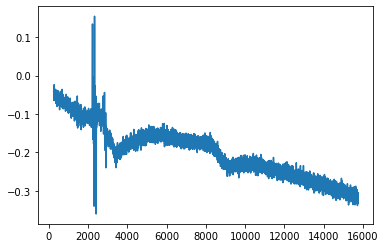

In [69]:
plt.plot(dta.data[0][0], dta.data[1][:, 5]);